# Table of Contents
1. [Imports](#Imports)
2. [Setup of Initial Variables](#setup_init_variables)
3. [Get Bitcoin Logo](#get_btc_logo)
4. [Utility Functions for Data Preprocessing](#util_data_preprocess)
5. [Download Data Sets](#download_datasets)
    - [Extraction of Blockchain Data](#blockchain_data)
    - [Extraction of Macroeconomic Data](#macroecon_data)
    - [Extraction of Exchange Data](#exchange_data)<br><br>
     - [Vizualize Exchange Data](#price_vizualization)
     - [Preprocess Exchange Data](#preprocess_exch_data)
     - [Plot Histogram of Daily Price Changes](#hist_daily_price_ch)<br><br>
    - [Extraction of Global Currencies Exchange Data](#global_curr_exch_data)
    - [Extraction of Sentiment Data](#sentiment_data)<br><br>
7. [Merge of All Data Source](#merge_data_source)
8. [Min-Max Scaling (a.k.a Normalization)](#normalization)
9. [Statistic of Data Prior Training](#statistics)
    - [Visualize the Whole Dataset](#viz_dataset)
    - [Looking for Trends](#sesonality_differentiation)
    - [Pearson Correlation](#pearson_corr)<br><br>
10. [ML Pipeline](#ml_pipeline)
   - [Split Data (Testing, Training Data Sets)](#split_data)
   - [Set Window Length](#win_len_metrics)
   - [Fill Training, Test Data](#fill_training_test)
   - [Load Model](#load_model)
   - [Train Model](#train_model)
   - [Graph Predicted Values with Training Set](#graph_pred_training_set)
   - [Graph Predicted Values with Test Data](#graph_pred_test_set)

### <a name="imports"></a>Imports

In [1]:
import sys
sys.executable # Set python3

from cryptory import Cryptory
import quandl
import time
import datetime

### <a name="setup_init_variables"></a>Setup Initial Variables

In [2]:
from_date="2013-04-28"
to_date=datetime.date.today().strftime("%Y-%m-%d")
my_cryptory = Cryptory(from_date=from_date)
quandl.ApiConfig.api_key = "eJns-j8GmckFnApoFoAE"
split_date = '2018-01-01'
# datetime.date(2018,1,1)

### <a name="util_data_preprocess"></a> Utility Functions for Data Preprocessing

In [3]:
import seaborn as sns
from cryptory import Cryptory
import datetime
import matplotlib.pyplot as plt
import urllib2 as urllib
import time
import numpy as np
import pandas as pd
from datetime import timedelta
import numpy as np

"""
    Function to make data from blockchain or other sources consistent with btc exchanged data
    If data from APIs has data since 2009 we omit those, if no data exist of a date, the previous date value is used
"""
def drop_initial_rows(api, new_col_name, start_date='2013-04-28'):
    # Read data 
    api_range_format= api
    data = pd.read_csv(urllib.urlopen(api_range_format))
    
    # Check if its the Block Size data
    if 'avg' in api:
        # Format columns
        data = pd.DataFrame(data.values, columns=['date', new_col_name])
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data['date'] = pd.DataFrame(data=data['date'], columns=['date'])

        data['date'] = pd.to_datetime(data['date'])

        # Add dates that do not appear at all, because their blocksize was same as the day before
        data = data.set_index('date').resample('D').ffill()

        # Reset index
        data.index.name='date'
        data = data.reset_index()
        data = data

        # Drop values before 2013, to be consistent with BTC Exchange dataset
        data = data.drop(data[data['date'] < '2013-04-28'].index)
        data = data.reset_index(drop=True)
        return data
        
    else:
        # Get the average block size from blockchain.info; max size ==> 1 MB (by design)
        df = data
        df = pd.DataFrame(df.values, columns=['date', new_col_name])
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df['date'] = pd.DataFrame(data=df['date'], columns=['date'])
        df['date']=df
        df['date'] = pd.to_datetime(df['date'])
        # Remove rows corresponding to dates before 2013-05-02
        df = df.set_index('date').resample('D').ffill()
        df.index.name='date'
        df.index.names = ['date']
        data = df.reset_index()
        df = data
        df[df['date'] < start_date]

        df = df.drop(df[df['date'] < start_date].index)
        df = df.reset_index(drop=True)
        return df

In [4]:
def rename_columns(prepend_to_name, df):
    df.columns = [df.columns[0]]+ \
                [str(prepend_to_name)+i for i in df.columns[1:]]

### <a name="download_datasets"></a> Download Data Sets

#### <a name="blockchain_data"></a> Extraction of Blockchain Data

In [5]:
# Get the average block size from blockchain.info; max size ==> 1 MB (by design)
block_size_api = "https://blockchain.info/charts/avg-block-size?timespan=all&format=csv" 
avg_block_size = drop_initial_rows(block_size_api, 'avg_block_size')

# Get transactions Daily
txs_api = "https://api.blockchain.info/charts/n-transactions?timespan=all&format=csv" 
txs_data = drop_initial_rows(txs_api, 'transactions')

## Data From Blockchain.info through Quandl API: https://www.quandl.com/data/BCHAIN-Blockchain

# Bitcoin Mining Difficulty
bchain_diff_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/DIFF.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_diff_data = drop_initial_rows(bchain_diff_api, 'difficulty')

# Bitcoin api.blockchain Size
# bchain_blchs_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/BLCHS.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
# bchain_blchs_data = drop_initial_rows(bchain_blchs_api, 'bchain_size')

# Rvenue of Bitcoin Miners
bchain_mirev_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/MIREV.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_mirev_data = drop_initial_rows(bchain_mirev_api, "mining_revenue")

# Bitcoin Hash Rate
bchain_hash_rate_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/CPTRA.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_hash_rate_data = drop_initial_rows(bchain_hash_rate_api, "hash_rate")
                       
# Bitcoin Cost Per Transaction
bchain_cpt_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/NADDU.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_cpt_data = drop_initial_rows(bchain_cpt_api, "cost_per_transaction")   

blockchain_data = avg_block_size.merge(txs_data, on='date', how='inner'). \
            merge(bchain_diff_data,on='date' ,how='inner'). \
            merge(bchain_mirev_data, on='date', how='inner'). \
            merge(bchain_hash_rate_data, on='date', how='inner'). \
            merge(bchain_cpt_data, on='date', how='inner')

In [6]:
# Gist of it
blockchain_data.tail()

,date,avg_block_size,transactions,difficulty,mining_revenue,hash_rate,cost_per_transaction
1970,2018-09-19,0.804437,251037,7.0192e+12,1.12962e+07,46.247,479308
1971,2018-09-20,0.804437,251037,7.0192e+12,1.24632e+07,49.6467,480227
1972,2018-09-21,1.0123,273051,7.03133e+12,1.24729e+07,49.1692,493140
1973,2018-09-22,1.0123,273051,7.15263e+12,1.21768e+07,44.5954,563130
1974,2018-09-23,0.655633,200319,7.15263e+12,1.31245e+07,58.1921,445041


#### <a name="macroecon_data"></a>Extraction of Macroeconomic Data

In [7]:
blockchain_data.isnull().values.any()

False

In [8]:
# S&P 500
s_and_p_stock = my_cryptory.get_stock_prices(market="%5EGSPC")
s_and_p_stock = s_and_p_stock.loc[:,['date', 'close']]
# Rename close column
s_and_p_stock = s_and_p_stock.rename(columns={'close': 'sp_close'})

In [9]:
# # Dow and Jones
# dow_jones_stock = my_cryptory.get_stock_prices(market="%5EDJI")
# dow_jones_stock = dow_jones_stock.loc[:,['date', 'close']]
# dow_jones_stock = dow_jones_stock.rename(columns={'close': 'dj_close'})

In [160]:
# # Nasdaq
# nasdaq_stock = my_cryptory.get_stock_prices(market="%5EIXIC")
# nasdaq_stock = nasdaq_stock.loc[:,['date', 'close']]
# nasdaq_stock = nasdaq_stock.rename(columns={'close': 'nasdaq_close'})

# # Vix
# vix_stock = my_cryptory.get_stock_prices(market="%5EVIX")
# vix_stock = vix_stock.loc[:,['date', 'close']]
# vix_stock = vix_stock.rename(columns={'close': 'vix_close'})

# # Commodity Prices
# metals_prices = my_cryptory.get_metal_prices()
# metals_prices = metals_prices[['date', 'gold_am', 'silver']]

# # Oil Price
# oil_price = my_cryptory.get_oil_prices()


In [10]:
macro_econ_data = s_and_p_stock

# macro_econ_data = s_and_p_stock.merge(dow_jones_stock,on='date', how='inner') \
#                 .merge(nasdaq_stock,on='date', how='inner') \
#                 .merge(vix_stock, on='date', how='inner') \
#                 .merge(metals_prices,on='date', how='inner') \
#                 .merge(oil_price, on='date', how='inner')


In [11]:
# Replace missing values in each attribute (except for data) with the mean of this features' value
for price_col in macro_econ_data:
    # Rule out date column
    if price_col == 'date':
        continue
    macro_econ_data[price_col].fillna(value=macro_econ_data[price_col].mean(),inplace=True)
    
print(macro_econ_data['sp_close'].isnull().sum())

0


#### <a name="exchange_data"></a> Extraction of Exchange Data

In [14]:
# Daily data from coinmarketcap
coinmarket_btc_market_info = my_cryptory.extract_coinmarketcap("bitcoin")

In [15]:
# Set date to correct type
# coinmarket_btc_market_info[coinmarket_btc_market_info['volume']==0]=coinmarket_btc_market_info['volume'].mean()
# need to reverse the data frame so that subsequent rows represent later timepoints
# coinmarket_btc_market_info = coinmarket_btc_market_info.sort_values(by='date')
coinmarket_btc_market_info['volume'].replace(to_replace=0, method='ffill')
fill_vol_data = coinmarket_btc_market_info['volume'].mean(skipna=True)

coinmarket_btc_market_info['volume']=coinmarket_btc_market_info['volume'].replace(fill_vol_data) 
print (fill_vol_data)

1347819902.2955465


##### <a name="price_vizualization"></a>Vizualize Exchange Data

In [165]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

btc_trace_high = go.Scatter(
                x=coinmarket_btc_market_info.date,
                y=coinmarket_btc_market_info['high'],
                name = "Bitcoin High",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

btc_trace_low = go.Scatter(
                x=coinmarket_btc_market_info.date,
                y=coinmarket_btc_market_info['low'],
                name = "Bitcoin Low",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)


data = [btc_trace_high,btc_trace_low]

layout = dict(
    title = "Levizjet ne Cmimin e Bitcoin",
    xaxis = dict(
        range = ['2013-04-28','2018-09-22'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Levizjet ne Cmimin e Bitcoin")

###### Sort coinmarket_btc_market_info

##### <a name="preprocess_exch_data"></a>Preprocess Exchange Data
Some columns were removed to add others, as below:

Removed: 
1. Open Price
2. High
3. Low

Added: 
1. **close_off_high** -> represents the _gap_ between closing price and price high
2. **voltility** -> difference between high and low prices divided by 2 


The data is arranged from earliest to latest
The date column won't be fed to the algorithm


In [173]:
############################################################################################
#######
####### Add New Columns
#######
############################################################################################
pd.DataFrame(coinmarket_btc_market_info).fillna(coinmarket_btc_market_info.mean())
coinmarket_btc_market_info['date']=pd.to_datetime(coinmarket_btc_market_info['date'])
# Housekeeping
for str_col in ['volume', 'close', 'open', 'low', 'high']:
    coinmarket_btc_market_info[str_col] = coinmarket_btc_market_info[str_col].astype('float')
    coinmarket_btc_market_info[str_col] = coinmarket_btc_market_info[str_col].astype('int64')

coinmarket_btc_market_info.columns = coinmarket_btc_market_info.columns.str.replace("*", "") 

rename_columns('bt_', coinmarket_btc_market_info)

# Calculate new columns
for coins in ['bt_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'close']-x[coins+'open'])/x[coins+'open']}
    coinmarket_btc_market_info = coinmarket_btc_market_info.assign(**kwargs)

for coins in ['bt_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'high']- x[coins+'close'])/(x[coins+'high']-x[coins+'low'])-1,
            coins+'volatility': lambda x: (x[coins+'high']- x[coins+'low'])/(x[coins+'open'])}
    coinmarket_btc_market_info = coinmarket_btc_market_info.assign(**kwargs)

KeyError: 'volume'

##### <a name="hist_daily_price_ch"></a>Plot Histogram of Daily Price Changes

Text(0.5,1,'Bitcoin Daily Price Changes')

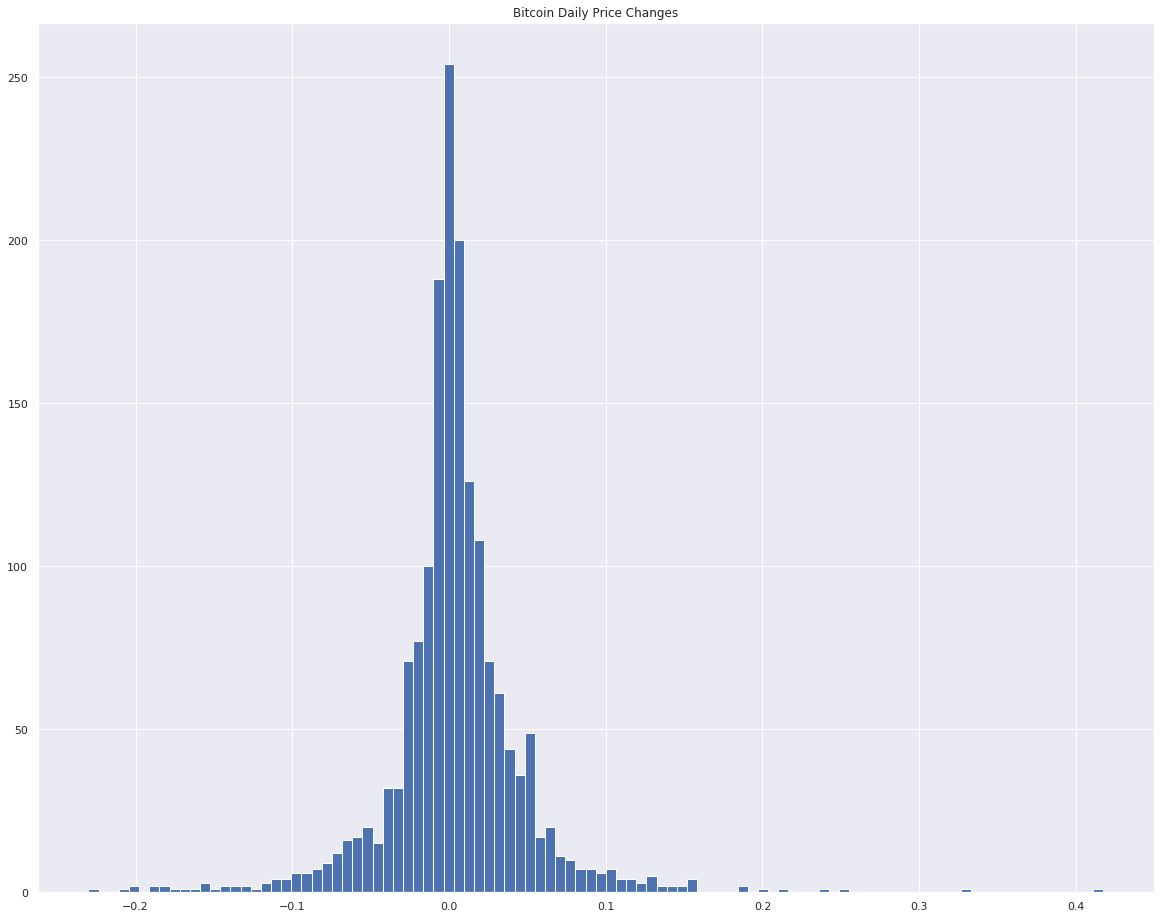

In [167]:
fig, ax1 = plt.subplots()
ax1.hist(coinmarket_btc_market_info[coinmarket_btc_market_info['date']< split_date]['bt_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')

In [174]:
# Drop unneccessary columns:
coinmarket_btc_market_info = coinmarket_btc_market_info.drop('bt_high', 1)
coinmarket_btc_market_info = coinmarket_btc_market_info.drop('bt_open', 1)
coinmarket_btc_market_info = coinmarket_btc_market_info.drop('bt_low', 1)
coinmarket_btc_market_info = coinmarket_btc_market_info.drop('bt_marketcap', 1)

KeyError: "['bt_high'] not found in axis"

#### <a name="global_curr_exch_data"></a> Global Currencies Exchange Data

In [169]:
# USD - EUR
eur_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")
eur_usd_exchange_rate = eur_usd_exchange_rate.rename(columns={'exch_rate': 'eur_exch_rate'})

# # USD - JPY
# jpy_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="JPY")
# jpy_usd_exchange_rate = jpy_usd_exchange_rate.rename(columns={'exch_rate': 'jpy_exch_rate'})

# # USD - Yuan
# cny_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="CNY")
# cny_usd_exchange_rate = cny_usd_exchange_rate.rename(columns={'exch_rate': 'cny_exch_rate'})


exchange_data = coinmarket_btc_market_info.merge(eur_usd_exchange_rate, on='date', how='inner')

# exchange_data = coinmarket_btc_market_info.merge(eur_usd_exchange_rate, on='date', how='inner'). \
#             merge(jpy_usd_exchange_rate,on='date' ,how='inner'). \
#             merge(cny_usd_exchange_rate, on='date', how='inner')

In [175]:
exchange_data.head()

,date,bt_close,bt_volume,bt_day_diff,bt_close_off_high,bt_volatility,eur_exch_rate
0,2018-09-24,6595,4177310000,-0.016259,0.774436,0.019839,1.1773
1,2018-09-23,6710,4197500000,-0.000745,0.287356,0.012956,1.1759
2,2018-09-22,6721,4509660000,-0.002079,-0.060606,0.029399,1.1759
3,2018-09-21,6734,6531940000,0.033932,-0.597315,0.045755,1.1759
4,2018-09-20,6519,4348110000,0.018912,-0.850746,0.020944,1.1769


#### <a name="sentiment_data"></a>Extraction of Sentiment Data

In [171]:
####################################################################################################################
########
######## Extract Sentiment Datacoinmarket_btc_market_info['date'] = pd.to_datetime(coinmarket_btc_market_info['date'],  errors='coerce')
########
####################################################################################################################
btc_google_trends = my_cryptory.get_google_trends(kw_list=['bitcoin'])
rename_columns('google_trends_', btc_google_trends)

,date,google_trends_bitcoin
0,2018-09-22,5.179875
1,2018-09-21,6.121670
2,2018-09-20,5.650773
3,2018-09-19,5.650773
4,2018-09-18,5.650773


In [177]:
btc_final
# # Leave our reddit for now
# btc_reddit_subscribers = my_cryptory.extract_reddit_metrics(subreddit="bitcoin", 
#                                          metric="total-subscribers")
# rename_columns('reddit_', btc_reddit_subscribers)

,bt_close,bt_volume,bt_day_diff,bt_close_off_high,bt_volatility,eur_exch_rate,google_trends_bitcoin,avg_block_size,transactions,difficulty,mining_revenue,hash_rate,cost_per_transaction,sp_close,date
0,0.003397,0.000000,-0.007407,0.333333,0.045206,0.436282,0.012655,0.049071,0.030598,0.000000e+00,0.005097,0.066453,0.067656,0.435353,2013-04-28
1,0.003912,0.000000,0.074627,0.230769,0.197356,0.765951,0.010634,0.049071,0.030598,0.000000e+00,0.006480,0.059779,0.034946,0.015114,2013-04-29
2,0.003654,0.000000,-0.034722,0.583333,0.169524,0.754527,0.009623,0.105899,0.050310,1.540689e-07,0.004220,0.046325,0.022583,0.018031,2013-04-30
3,0.002471,0.000000,-0.165468,0.718750,0.468325,0.754527,0.014677,0.105899,0.050310,1.540689e-07,0.002647,0.033686,0.023341,0.007078,2013-05-01
4,0.001904,0.000000,-0.094828,0.606061,0.578719,0.787685,0.015688,0.110147,0.071724,1.540689e-07,0.001536,0.020584,0.029205,0.018046,2013-05-02
5,0.001493,0.000000,-0.084906,0.379310,0.556550,0.766230,0.015688,0.110147,0.071724,1.540689e-07,0.000839,0.017487,0.031587,0.030442,2013-05-03
6,0.002265,0.000000,0.142857,0.130435,0.477434,0.766230,0.010634,0.077911,0.049184,1.540689e-07,0.002521,0.035212,0.017974,0.030442,2013-05-04
7,0.002419,0.000000,0.026786,0.272727,0.199796,0.766230,0.010634,0.077911,0.049184,1.540689e-07,0.002947,0.036855,0.017837,0.030442,2013-05-05
8,0.002265,0.000000,-0.026087,0.666667,0.318410,0.764280,0.012655,0.081758,0.056492,1.540689e-07,0.003714,0.039769,0.025957,0.032711,2013-05-06
9,0.002213,0.000000,-0.008929,0.125000,0.290612,0.764280,0.008612,0.081758,0.056492,1.540689e-07,0.003257,0.028910,0.050177,0.038942,2013-05-07


### <a name="merge_data_source"></a>Merge of All Data Source

In [115]:
btc_final = exchange_data.merge(btc_google_trends, on='date', how='inner'). \
            merge(blockchain_data,on='date' ,how='inner'). \
            merge(macro_econ_data, on='date', how='inner')

In [116]:
# need to reverse the data frame so that subsequent rows represent later timepoints
btc_final = btc_final.assign(date=pd.to_datetime(btc_final['date']))
btc_final = btc_final.sort_values(by='date')
# btc_final.reindex(index=btc_final.index[::-1])

In [117]:
print(btc_final)

           date  bt_close   bt_volume  bt_day_diff  bt_close_off_high  \
1973 2013-04-28       134           0    -0.007407          -0.333333   
1972 2013-04-29       144           0     0.074627          -0.538462   
1971 2013-04-30       139           0    -0.034722           0.166667   
1970 2013-05-01       116           0    -0.165468           0.437500   
1969 2013-05-02       105           0    -0.094828           0.212121   
1968 2013-05-03        97           0    -0.084906          -0.241379   
1967 2013-05-04       112           0     0.142857          -0.739130   
1966 2013-05-05       115           0     0.026786          -0.454545   
1965 2013-05-06       112           0    -0.026087           0.333333   
1964 2013-05-07       111           0    -0.008929          -0.750000   
1963 2013-05-08       113           0     0.036697          -0.333333   
1962 2013-05-09       112           0    -0.008850          -0.500000   
1961 2013-05-10       117           0     0.044643 

### <a name="normalization"></a>Min-Max Scaling (a.k.a Normalization)

In [118]:
# NORMALIZE USING MIN-MAX METHOD INSTEAD OF STANDARDIZATION
from sklearn.preprocessing import minmax_scale
import numpy as np
from sklearn.preprocessing import Imputer, StandardScaler

btc_final.fillna(btc_final.mean(),inplace=True)

mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

btc_without_date = btc_final.loc[:, btc_final.columns != 'date']

# Train the imputor on the df dataset
mean_imputer = mean_imputer.fit(btc_without_date)

# Apply the imputer to the df dataset
imputed_df = mean_imputer.transform(btc_without_date)

# Get back columns
imputed_df = pd.DataFrame(imputed_df, columns = btc_without_date.columns)

# # From numpy array to numpy list
# all_columns_list = btc_final.columns.values.tolist()

imputed_df[['eur_exch_rate','bt_close', 'bt_volume', 'bt_close_off_high', 'bt_volatility', 'google_trends_bitcoin', 'avg_block_size', 'transactions', 'difficulty', 'mining_revenue', 'hash_rate', 'cost_per_transaction', 'sp_close']] = \
        minmax_scale(imputed_df[['eur_exch_rate','bt_close', 'bt_volume', 'bt_close_off_high', 'bt_volatility', 'google_trends_bitcoin', 'avg_block_size', 'transactions', 'difficulty', 'mining_revenue', 'hash_rate', 'cost_per_transaction', 'sp_close']])

# imputed_df[['eur_exch_rate', 'jpy_exch_rate', 'cny_exch_rate', 'bt_close', 'bt_volume', 'bt_close_off_high', 'bt_volatility', 'google_trends_bitcoin', 'avg_block_size', 'transactions', 'difficulty', 'bchain_size', 'mining_revenue', 'hash_rate', 'cost_per_transaction', 'sp_close', 'dj_close', 'nasdaq_close', 'vix_close', 'gold_am', 'silver', 'oil_price']] = \
#         minmax_scale(imputed_df[['eur_exch_rate', 'jpy_exch_rate', 'cny_exch_rate', 'bt_close', 'bt_volume', 'bt_close_off_high', 'bt_volatility', 'google_trends_bitcoin', 'avg_block_size', 'transactions', 'difficulty', 'bchain_size', 'mining_revenue', 'hash_rate', 'cost_per_transaction', 'sp_close', 'dj_close', 'nasdaq_close', 'vix_close', 'gold_am', 'silver', 'oil_price']])

# Re add date column
imputed_df['date'] = btc_final['date']

# Order by date
imputed_df["date"] = imputed_df["date"].values[::-1]

btc_final=imputed_df

In [119]:
# STANDARDIZING DATA=NONO; DATA DIFFERS LARGELY
# from sklearn.preprocessing import StandardScaler
# std_scale = StandardScaler().fit(btc_without_date)
# df_std = std_scale.transform(btc_without_date)


# pd.isnull(btc_without_date).sum() > 0

# print(df_std)

In [120]:
# Reindex, starting from 0 
btc_final.index = range(len(btc_final))
print(len(btc_final))

1974


### <a name="statistics"></a>Statistic of Data Prior Training

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

#### <a name="viz_dataset"></a> Visualize the Whole Dataset

#### <a name="sesonality_differentiation"></a>Looking for Trends

0      2013-04-28
1      2013-04-29
2      2013-04-30
3      2013-05-01
4      2013-05-02
5      2013-05-03
6      2013-05-04
7      2013-05-05
8      2013-05-06
9      2013-05-07
10     2013-05-08
11     2013-05-09
12     2013-05-10
13     2013-05-11
14     2013-05-12
15     2013-05-13
16     2013-05-14
17     2013-05-15
18     2013-05-16
19     2013-05-17
20     2013-05-18
21     2013-05-19
22     2013-05-20
23     2013-05-21
24     2013-05-22
25     2013-05-23
26     2013-05-24
27     2013-05-25
28     2013-05-26
29     2013-05-27
          ...    
1944   2018-08-24
1945   2018-08-25
1946   2018-08-26
1947   2018-08-27
1948   2018-08-28
1949   2018-08-29
1950   2018-08-30
1951   2018-08-31
1952   2018-09-01
1953   2018-09-02
1954   2018-09-03
1955   2018-09-04
1956   2018-09-05
1957   2018-09-06
1958   2018-09-07
1959   2018-09-08
1960   2018-09-09
1961   2018-09-10
1962   2018-09-11
1963   2018-09-12
1964   2018-09-13
1965   2018-09-14
1966   2018-09-15
1967   2018-09-16
1968   201

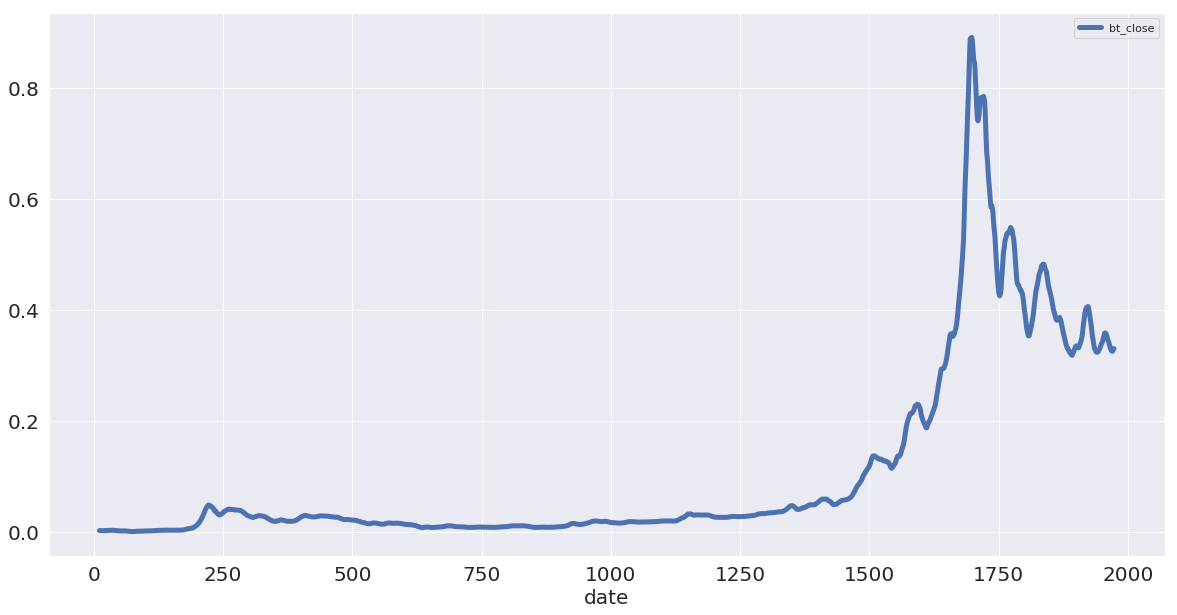

In [122]:
# Trying to get out of the graph up, we check for seasonality
btc_close_price = btc_final[['bt_close']]
btc_close_price.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('date', fontsize=20);

# yen = btc_final[['jpy_exch_rate']]
# yen.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
# plt.xlabel('Year', fontsize=20);

print(btc_final['date'])

In [123]:
btc_final

,bt_close,bt_volume,bt_day_diff,bt_close_off_high,bt_volatility,eur_exch_rate,google_trends_bitcoin,avg_block_size,transactions,difficulty,mining_revenue,hash_rate,cost_per_transaction,sp_close,date
0,0.003397,0.000000,-0.007407,0.333333,0.045206,0.436282,0.012655,0.049071,0.030598,0.000000e+00,0.005097,0.066453,0.067656,0.435353,2013-04-28
1,0.003912,0.000000,0.074627,0.230769,0.197356,0.765951,0.010634,0.049071,0.030598,0.000000e+00,0.006480,0.059779,0.034946,0.015114,2013-04-29
2,0.003654,0.000000,-0.034722,0.583333,0.169524,0.754527,0.009623,0.105899,0.050310,1.540689e-07,0.004220,0.046325,0.022583,0.018031,2013-04-30
3,0.002471,0.000000,-0.165468,0.718750,0.468325,0.754527,0.014677,0.105899,0.050310,1.540689e-07,0.002647,0.033686,0.023341,0.007078,2013-05-01
4,0.001904,0.000000,-0.094828,0.606061,0.578719,0.787685,0.015688,0.110147,0.071724,1.540689e-07,0.001536,0.020584,0.029205,0.018046,2013-05-02
5,0.001493,0.000000,-0.084906,0.379310,0.556550,0.766230,0.015688,0.110147,0.071724,1.540689e-07,0.000839,0.017487,0.031587,0.030442,2013-05-03
6,0.002265,0.000000,0.142857,0.130435,0.477434,0.766230,0.010634,0.077911,0.049184,1.540689e-07,0.002521,0.035212,0.017974,0.030442,2013-05-04
7,0.002419,0.000000,0.026786,0.272727,0.199796,0.766230,0.010634,0.077911,0.049184,1.540689e-07,0.002947,0.036855,0.017837,0.030442,2013-05-05
8,0.002265,0.000000,-0.026087,0.666667,0.318410,0.764280,0.012655,0.081758,0.056492,1.540689e-07,0.003714,0.039769,0.025957,0.032711,2013-05-06
9,0.002213,0.000000,-0.008929,0.125000,0.290612,0.764280,0.008612,0.081758,0.056492,1.540689e-07,0.003257,0.028910,0.050177,0.038942,2013-05-07


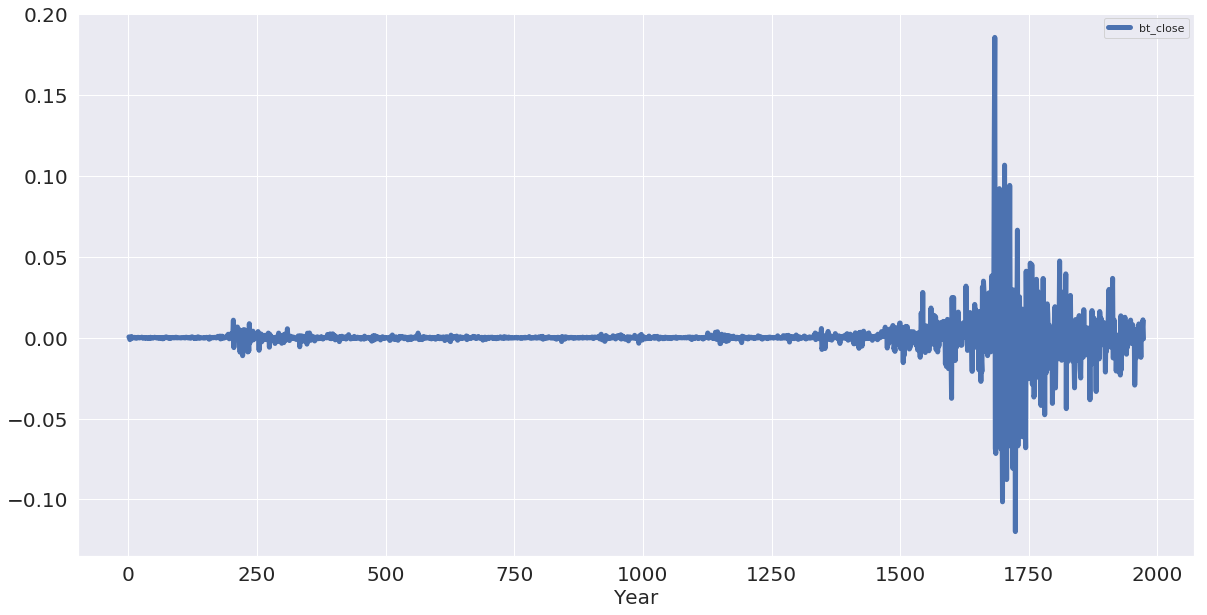

In [124]:
# First Order Differencing
btc_close_price.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
"""
    Removing the trends seems almost atrocious; The bubbles are very apparent
"""
plt.xlabel('Year', fontsize=20);

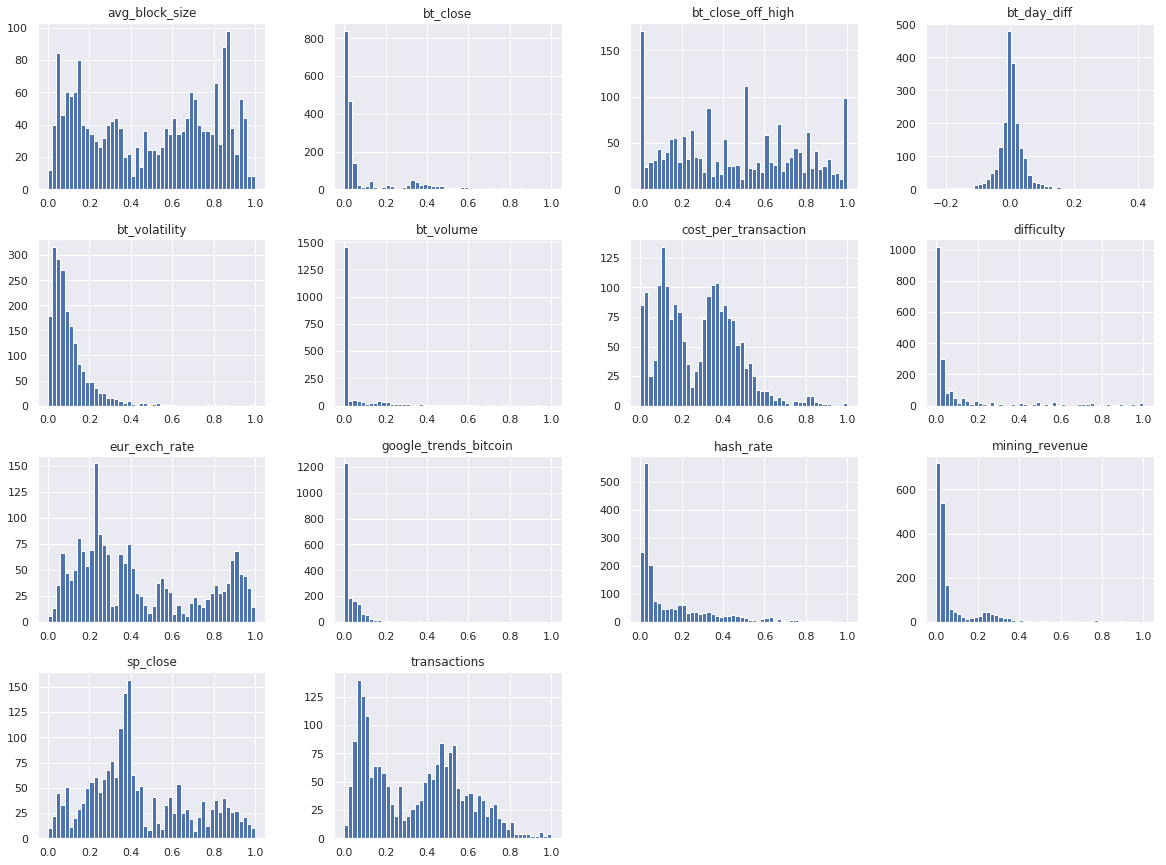

In [62]:
btc_final.hist(bins=50, figsize=(20,15))
# print(all_coins_df)
plt.show()

#### <a name="pearson_corr"></a> Pearson Correlation

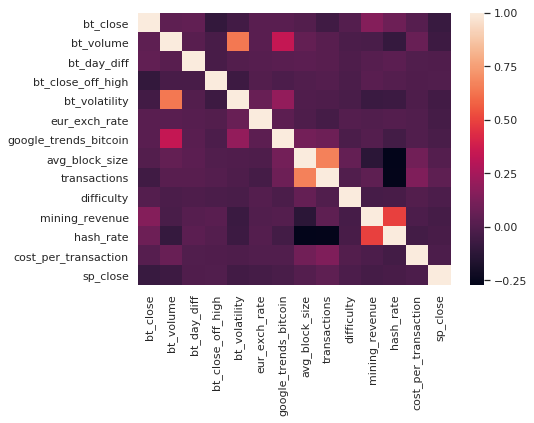

,bt_close,bt_volume,bt_day_diff,bt_close_off_high,bt_volatility,eur_exch_rate,google_trends_bitcoin,avg_block_size,transactions,difficulty,mining_revenue,hash_rate,cost_per_transaction,sp_close
bt_close,1,0.041,0.05,-0.097,-0.049,0.022,0.024,0.0072,-0.055,0.011,0.15,0.084,0.017,-0.08
bt_volume,0.041,1,0.021,-0.031,0.64,0.026,0.34,0.054,0.021,-0.019,-0.023,-0.091,0.07,-0.063
bt_day_diff,0.05,0.021,1,-0.028,0.0055,0.012,0.026,0.03,0.017,-0.011,0.015,0.029,0.00066,-0.0065
bt_close_off_high,-0.097,-0.031,-0.028,1,-0.063,0.0049,-0.016,-0.0012,0.01,-0.02,0.025,0.0084,-0.0026,0.00096
bt_volatility,-0.049,0.64,0.0055,-0.063,1,0.068,0.2,-0.0032,-0.011,-0.024,-0.074,-0.071,-0.0095,-0.052
eur_exch_rate,0.022,0.026,0.012,0.0049,0.068,1,0.033,-0.0078,-0.039,0.0093,-0.0012,0.012,-0.0014,-0.042
google_trends_bitcoin,0.024,0.34,0.026,-0.016,0.2,0.033,1,0.1,0.085,-0.02,0.012,-0.044,0.0013,-0.027
avg_block_size,0.0072,0.054,0.03,-0.0012,-0.0032,-0.0078,0.1,1,0.67,0.061,-0.12,-0.27,0.1,0.0096
transactions,-0.055,0.021,0.017,0.01,-0.011,-0.039,0.085,0.67,1,-0.00059,0.04,-0.26,0.14,0.041
difficulty,0.011,-0.019,-0.011,-0.02,-0.024,0.0093,-0.02,0.061,-0.00059,1,-0.037,-0.029,0.0069,-0.017


In [192]:
# Pearson correlation on all attributes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"""DROP DATE COLUMN!"""
all_features_df = btc_final.loc[:, btc_final.columns != 'date']

# Percentage change => 
# first calculate: Increase = y_t - y_(t-1) then calculate: %Increace = (Increase-y_(t-1))*100
"""
    %Increase is used both to track the prices of individual securities and 
    of large market indexes, as well as comparing the values of different currencies.  
    Balance sheets with comparative financial statements will generally include the 
    prices of specific assets at different points in time along with the percentage 
    changes over the accompanying periods of time.  
"""
# Compute pairwise correlation of columns, excluding NA/null values
corr = all_features_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            annot_kws={"size": 16})
plt.show()


# Table view for readibility
# cmap=sns.diverging_palette(5, 250, as_cmap=True)
cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

### <a name="ml_pipeline"></a> ML Pipeline
#### <a name="split_data"></a> Split Data (Testing, Training Data Sets)

In [125]:
# need to reverse the data frame so that subsequent rows represent later timepoints
# btc_final = btc_final.sort_values(by='date')
# btc_final = pd.read_csv("btc_final.csv").iloc[:, 1:]
# btc_final = btc_final.drop('bt_day_diff', 1)
training_set, test_set = btc_final[btc_final['date']<split_date], btc_final[btc_final['date']>=split_date]
training_set = training_set.drop('date', 1)
test_set = test_set.drop('date', 1)
print(btc_final)

      bt_close  bt_volume  bt_day_diff  bt_close_off_high  bt_volatility  \
0     0.003397   0.000000    -0.007407           0.333333       0.045206   
1     0.003912   0.000000     0.074627           0.230769       0.197356   
2     0.003654   0.000000    -0.034722           0.583333       0.169524   
3     0.002471   0.000000    -0.165468           0.718750       0.468325   
4     0.001904   0.000000    -0.094828           0.606061       0.578719   
5     0.001493   0.000000    -0.084906           0.379310       0.556550   
6     0.002265   0.000000     0.142857           0.130435       0.477434   
7     0.002419   0.000000     0.026786           0.272727       0.199796   
8     0.002265   0.000000    -0.026087           0.666667       0.318410   
9     0.002213   0.000000    -0.008929           0.125000       0.290612   
10    0.002316   0.000000     0.036697           0.333333       0.111979   
11    0.002265   0.000000    -0.008850           0.250000       0.072010   
12    0.0025

In [126]:
# Only one row with bt_close=0 was detected => set it to the value of previous row
print(np.count_nonzero(training_set==0))

training_set[training_set['bt_close'] == 0]
training_set.loc[68]['bt_close'] = training_set.loc[67]['bt_close'] 

506


In [127]:
np.all(training_set==0)
# btc_final.to_csv('btc_final.csv')

False

In [128]:
# test = btc_final.copy()
# test.date_index = pd.to_datetime(test['date'])
# test.set_index('date', inplace=True)
# test.plot(figsize=(20,10), linewidth=4, fontsize=20)
# plt.xlabel('date', fontsize=20);


# print(btc_final['bt_close_off_high']-btc_final['bt_close'])

#### <a name="win_len_metrics"></a> Set Window Length

In [129]:
window_len = 60
norm_cols = ['bt_close','bt_volume']
# print(training_set)

#### <a name="fill_training_test"></a>Fill Training, Test Data

In [130]:
LSTM_training_inputs = []
# print(training_set[0:(0+window_len)].copy())
for i in range(len(training_set)-window_len): # 
    temp_set = training_set[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_close'][window_len:].values/training_set['bt_close'][:-window_len].values)-1

In [131]:
print(LSTM_training_outputs)

[-0.5        -0.65789474 -0.63380282 ...  1.40646651  1.013125
  1.10300045]


In [132]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_close'][window_len:].values/test_set['bt_close'][:-window_len].values)-1
print(LSTM_test_outputs)

[-0.18919714 -0.23420947 -0.24377189 -0.25922349 -0.38304245 -0.43312905
 -0.43159242 -0.38624023 -0.39436911 -0.36195907 -0.3149134  -0.34401955
 -0.42618248 -0.39929947 -0.39858919 -0.31290492 -0.26663669 -0.24934245
 -0.2334691  -0.30940691 -0.24904613 -0.18889809 -0.2037037  -0.25365335
 -0.27254043 -0.30063947 -0.30654238 -0.39435057 -0.39241183 -0.31211397
 -0.33261105 -0.22929027 -0.15681351 -0.25488689 -0.17858448 -0.04631915
 -0.10967994 -0.07917384 -0.1823838  -0.21942778 -0.19326552 -0.02977298
 -0.11639196 -0.07174678 -0.12359431 -0.20875421 -0.22931628 -0.26702282
 -0.21530096 -0.21331899 -0.22126158 -0.1777443  -0.10818154 -0.05902472
 -0.09933299 -0.03991246 -0.1339095  -0.12921085 -0.09468487 -0.15721768
 -0.17852605 -0.19735575 -0.15457882 -0.16279878 -0.08598637 -0.03142366
 -0.00235874 -0.01111231  0.05217095 -0.05625657 -0.08361607 -0.07560815
  0.0553591   0.0505345   0.02079807  0.05759429 -0.01581852 -0.04438215
 -0.07529678 -0.0469473  -0.03579677 -0.09510839 -0

In [133]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

#### <a name="load_model"></a>Load Model


##### Theory of LSTMs: 
- [this](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [this](http://blog.echen.me/2017/05/30/exploring-lstms/)
- [this](http://www.bioinf.jku.at/publications/older/2604.pdf). 


In [134]:
# %load models/lstm_model.py
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras import optimizers
"""
    If network is overfitting => decrease batch size; the vice-versa for underfitting
"""
# def lstm_model(inputs, output_size, neurons, optimizer="sgd", loss="mae", activ_func="relu",
#                 dropout=0.3): 
def lstm_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.3, loss="mae", optimizer="adam"):    
    print(inputs.shape[1])
    print(inputs.shape[2])
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

#### <a name="train_model"></a>Train Model 

In [135]:
%matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

# Optmizer
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next :pred_range days 
# change this value if you want to make longer/shorter prediction
pred_range = 30

# initialise model architecture
bt_model = lstm_model(LSTM_training_inputs, output_size=pred_range, neurons = 10)
# bt_model = gru_model(LSTM_training_inputs, output_size=pred_range, neurons=32)

# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_close'][i:i+pred_range].values/
                                  training_set['bt_close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: bt_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=100, batch_size=50, verbose=2, shuffle=True)

60
14
Epoch 1/100
 - 1s - loss: 0.8629
Epoch 2/100
 - 1s - loss: 0.8368
Epoch 3/100
 - 1s - loss: 0.8107
Epoch 4/100
 - 1s - loss: 0.7824
Epoch 5/100
 - 1s - loss: 0.7691
Epoch 6/100
 - 1s - loss: 0.7616
Epoch 7/100
 - 1s - loss: 0.7552
Epoch 8/100
 - 1s - loss: 0.7484
Epoch 9/100
 - 1s - loss: 0.7418
Epoch 10/100
 - 1s - loss: 0.7367
Epoch 11/100
 - 1s - loss: 0.7329
Epoch 12/100
 - 1s - loss: 0.7267
Epoch 13/100
 - 1s - loss: 0.7197
Epoch 14/100
 - 1s - loss: 0.7066
Epoch 15/100
 - 1s - loss: 0.7011
Epoch 16/100
 - 1s - loss: 0.6767
Epoch 17/100
 - 1s - loss: 0.6554
Epoch 18/100
 - 1s - loss: 0.6417
Epoch 19/100
 - 1s - loss: 0.6197
Epoch 20/100
 - 1s - loss: 0.5977
Epoch 21/100
 - 1s - loss: 0.5764
Epoch 22/100
 - 1s - loss: 0.5572
Epoch 23/100
 - 1s - loss: 0.5601
Epoch 24/100
 - 1s - loss: 0.5530
Epoch 25/100
 - 1s - loss: 0.5351
Epoch 26/100
 - 1s - loss: 0.5201
Epoch 27/100
 - 1s - loss: 0.5058
Epoch 28/100
 - 1s - loss: 0.5075
Epoch 29/100
 - 1s - loss: 0.5055
Epoch 30/100
 - 1

#### <a name="graph_pred_training_set"></a>Graph Predicted Values with Training Set

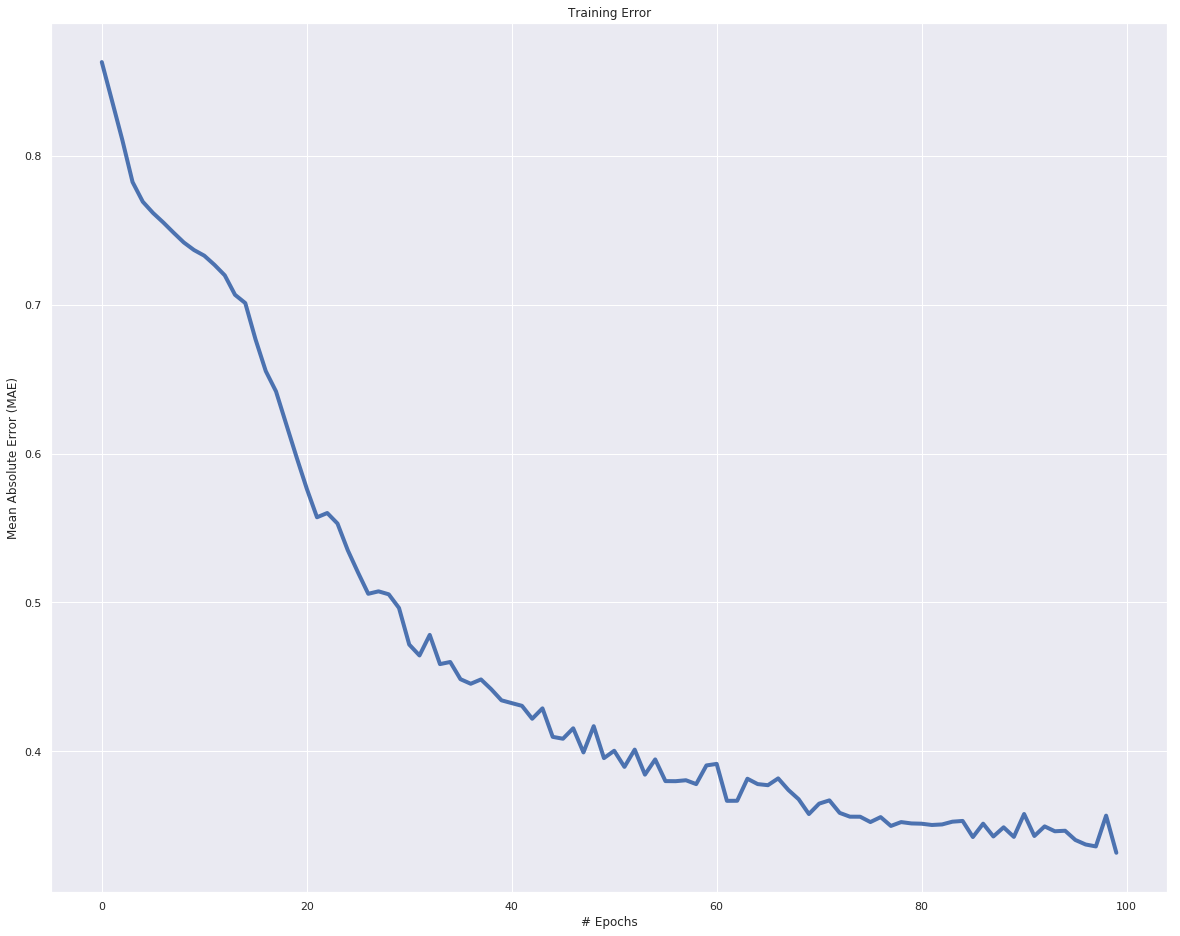

In [136]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(bt_history.epoch, bt_history.history['loss'])
ax1.set_title('Training Error')

if bt_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

In [137]:
bt_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                1000      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                330       
_________________________________________________________________
activation_3 (Activation)    (None, 30)                0         
Total params: 1,330
Trainable params: 1,330
Non-trainable params: 0
_________________________________________________________________


In [138]:
btc_final[btc_final['date']< split_date]['date'][window_len:]

60     2013-06-27
61     2013-06-28
62     2013-06-29
63     2013-06-30
64     2013-07-01
65     2013-07-02
66     2013-07-03
67     2013-07-04
68     2013-07-05
69     2013-07-06
70     2013-07-07
71     2013-07-08
72     2013-07-09
73     2013-07-10
74     2013-07-11
75     2013-07-12
76     2013-07-13
77     2013-07-14
78     2013-07-15
79     2013-07-16
80     2013-07-17
81     2013-07-18
82     2013-07-19
83     2013-07-20
84     2013-07-21
85     2013-07-22
86     2013-07-23
87     2013-07-24
88     2013-07-25
89     2013-07-26
          ...    
1679   2017-12-02
1680   2017-12-03
1681   2017-12-04
1682   2017-12-05
1683   2017-12-06
1684   2017-12-07
1685   2017-12-08
1686   2017-12-09
1687   2017-12-10
1688   2017-12-11
1689   2017-12-12
1690   2017-12-13
1691   2017-12-14
1692   2017-12-15
1693   2017-12-16
1694   2017-12-17
1695   2017-12-18
1696   2017-12-19
1697   2017-12-20
1698   2017-12-21
1699   2017-12-22
1700   2017-12-23
1701   2017-12-24
1702   2017-12-25
1703   201

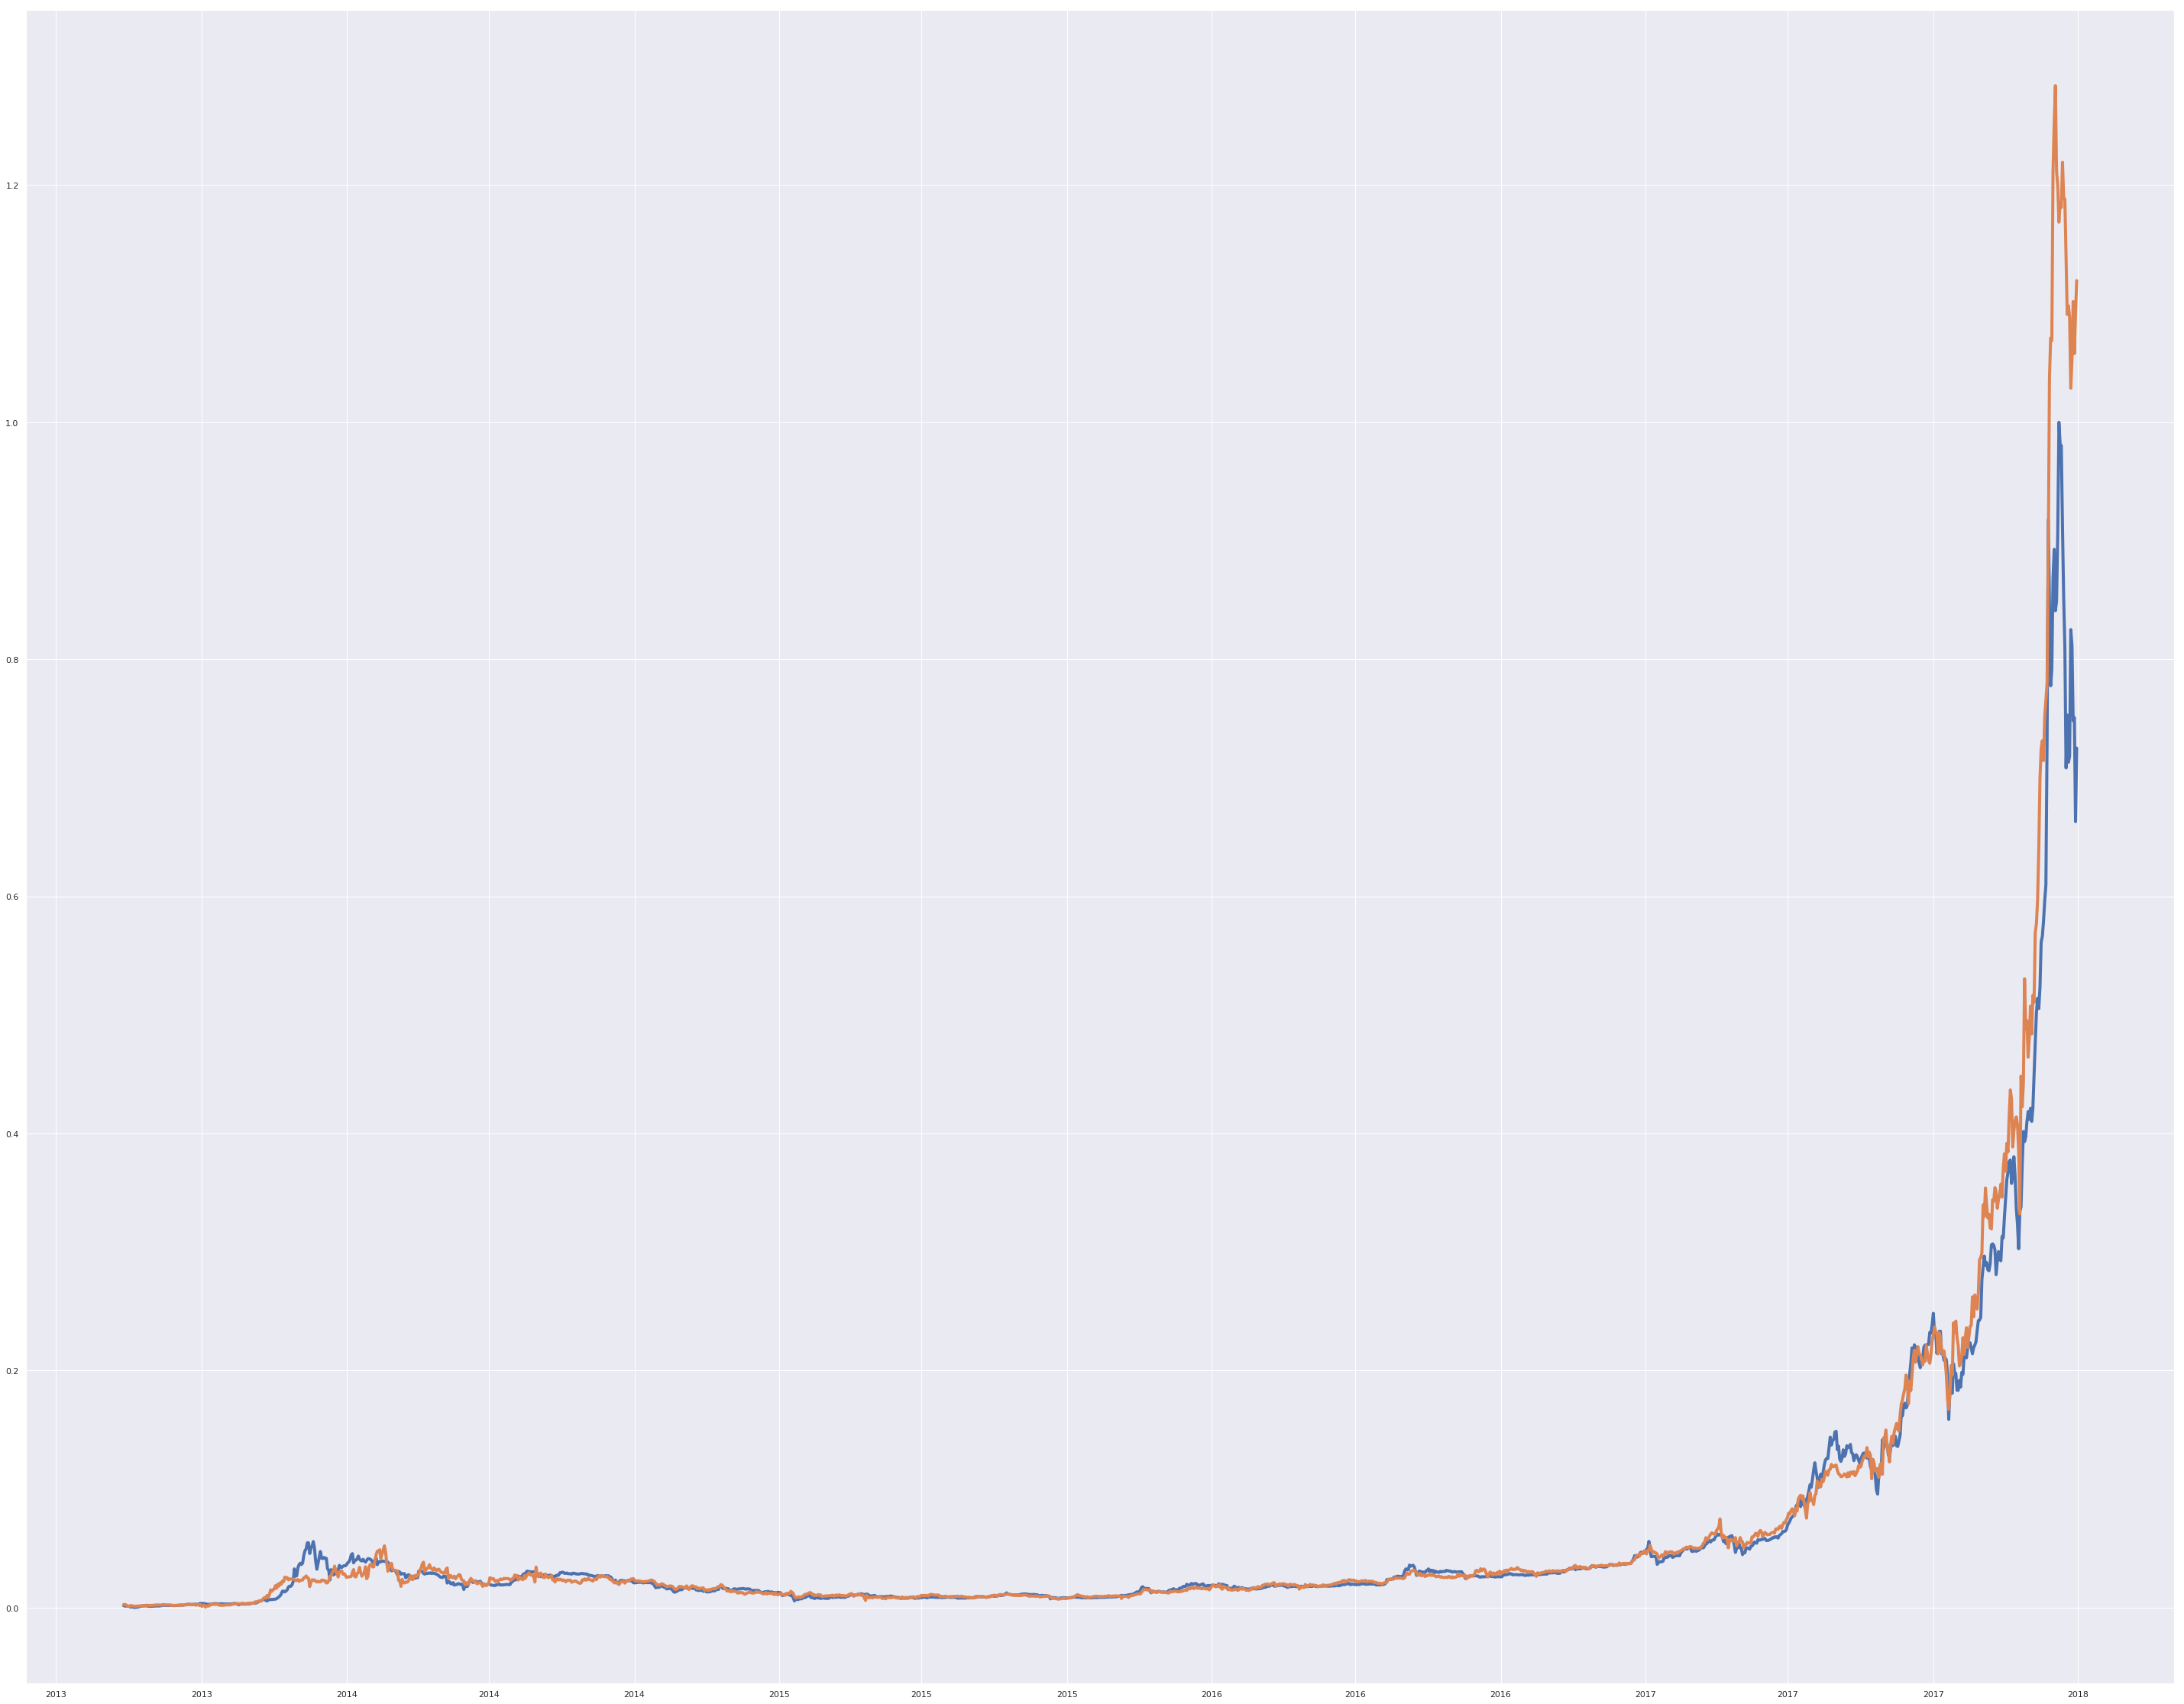

In [139]:
%matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
fig.clear()
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])

ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')

ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')

ax1.set_title('Training Set: Predicting ' + str(pred_range) + ' data points in the future')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_close'].values[window_len:])/(training_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
# axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
# axins.set_ylim([920, 1400])
# mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

#### <a name="graph_pred_test_set"></a> Graph Predicted Values with Test Data

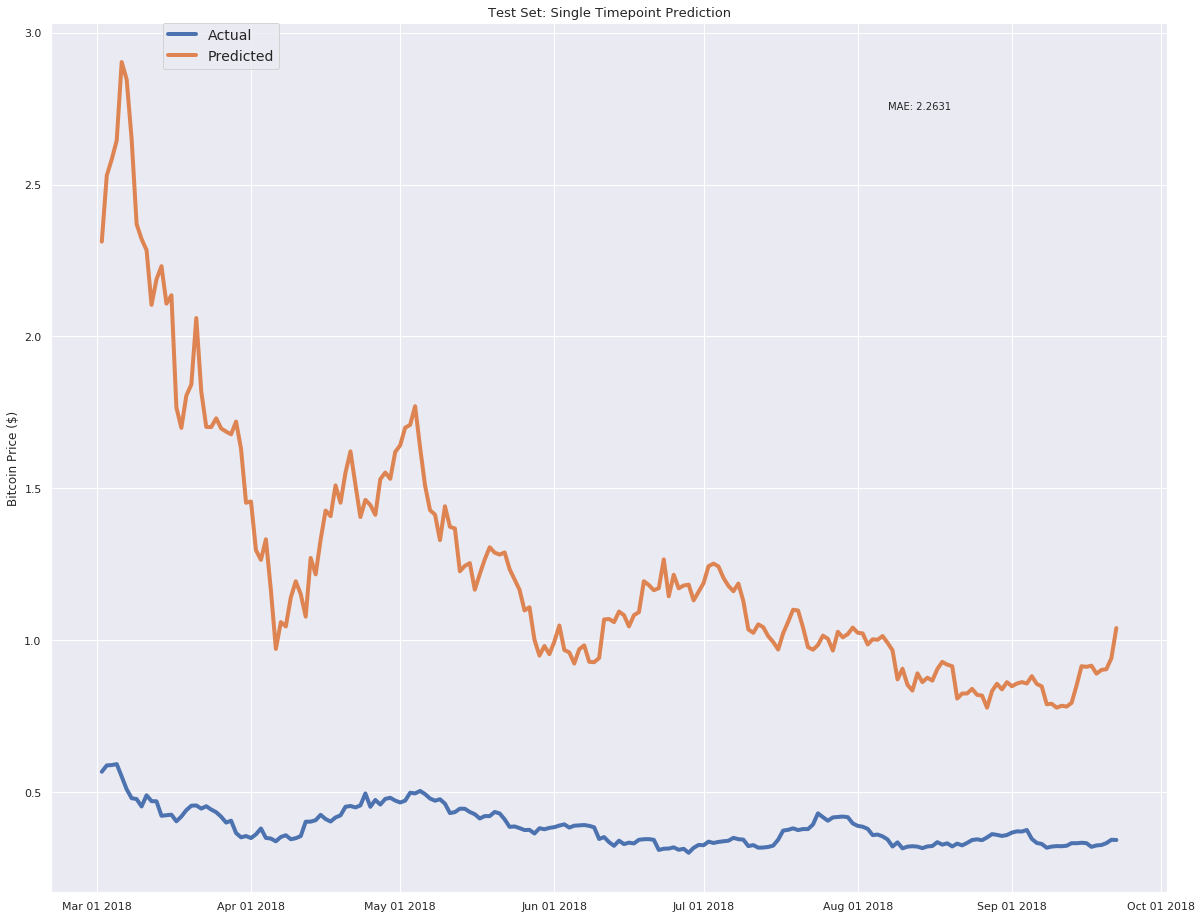

In [150]:

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['bt_close'][window_len:], label='Actual')
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_close'].values[window_len:])/(test_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [145]:
print(window_len)

60


In [148]:
print(split_date)

2018-01-01
